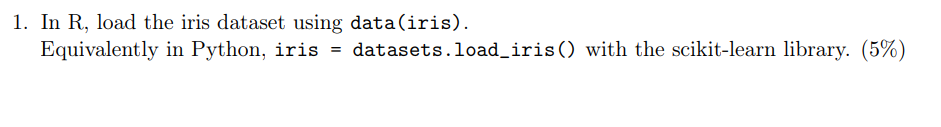

In [84]:
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


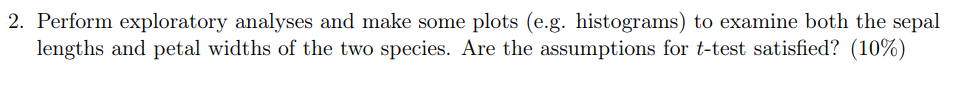

[1] setosa     versicolor virginica 
Levels: setosa versicolor virginica

[1] "Shapiro Wilk test p-values -----------------------------------------"


,Setosa,Versicolor,Virginica
Sepal Lenght,4.595132e-01,0.4647370,0.25831475
Petal Width,8.658573e-07,0.0272778,0.08695419


[1] "Variance equality test p-values ------------------------------------"
[1] "Sepal Lengths ......................................................"


,Setosa,Versicolor,Virginica
Setosa,NA,0.008657188,6.366473e-05
Versicolor,8.657188e-03,NA,1.477910e-01
Virginica,6.366473e-05,0.147790978,NA


[1] "Petal widths ....................................................."


,Setosa,Versicolor,Virginica
Setosa,NA,2.128794e-05,4.172759e-10
Versicolor,2.128794e-05,NA,2.334861e-02
Virginica,4.172759e-10,2.334861e-02,NA


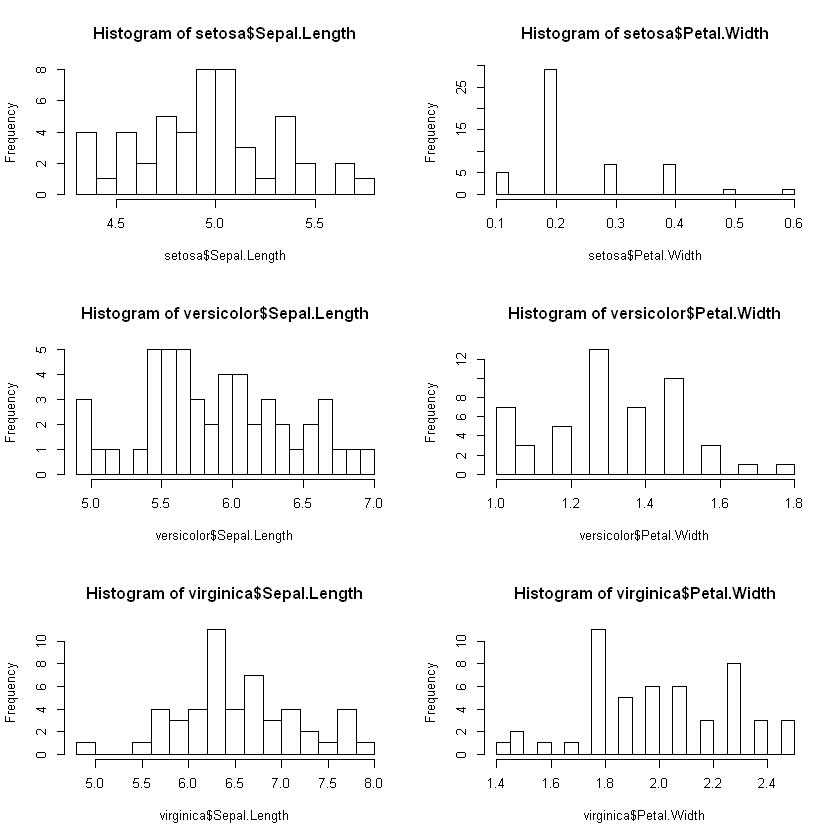

In [85]:
# checking for unique species
unique(iris$Species)

# subsetting the dataset by species
setosa <- iris[iris$Species == 'setosa',]
versicolor <- iris[iris$Species == 'versicolor',]
virginica <- iris[iris$Species == 'virginica',]

# histograms
par(mfrow = c(3,2))

hist(setosa$Sepal.Length, breaks = 20)
hist(setosa$Petal.Width, breaks = 20)

hist(versicolor$Sepal.Length, breaks = 20)
hist(versicolor$Petal.Width, breaks = 20)

hist(virginica$Sepal.Length, breaks = 20)
hist(virginica$Petal.Width, breaks = 20)

# Shapiro-Wilk test for the normality assumption
print('Shapiro Wilk test p-values -----------------------------------------')

species <- c('Setosa', 'Versicolor', 'Virginica')
features <- c('Sepal Lenght', 'Petal Width')
shapiro_df <- data.frame(matrix(nrow = 2, ncol = 3))
colnames(shapiro_df) <- species
rownames(shapiro_df) <- features

shapiro_df[1,1] <- shapiro.test(setosa$Sepal.Length)$p.value
shapiro_df[2,1] <- shapiro.test(setosa$Petal.Width)$p.value

shapiro_df[1,2] <- shapiro.test(versicolor$Sepal.Length)$p.value
shapiro_df[2,2] <- shapiro.test(versicolor$Petal.Width)$p.value

shapiro_df[1,3] <- shapiro.test(virginica$Sepal.Length)$p.value
shapiro_df[2,3] <- shapiro.test(virginica$Petal.Width)$p.value

shapiro_df

# testing for the equal variance assumption
print('Variance equality test p-values ------------------------------------')
var_df <- data.frame(matrix(nrow = 3, ncol = 3))
rownames(var_df) <- species
colnames(var_df) <- species
print('Sepal Lengths ......................................................')
var_df[1,2] <- var.test(setosa$Sepal.Length, versicolor$Sepal.Length)$p.value
var_df[2,1] <- var_df[1,2]
var_df[1,3] <- var.test(setosa$Sepal.Length, virginica$Sepal.Length)$p.value
var_df[3,1] <- var_df[1,3]
var_df[2,3] <- var.test(versicolor$Sepal.Length, virginica$Sepal.Length)$p.value
var_df[3,2] <- var_df[2,3]
var_df
var_df2 <- data.frame(matrix(nrow = 3, ncol = 3))
rownames(var_df2) <- species
colnames(var_df2) <- species
print('Petal widths .....................................................')
var_df2[1,2] <- var.test(setosa$Petal.Width, versicolor$Petal.Width)$p.value
var_df2[2,1] <- var_df2[1,2]
var_df2[1,3] <- var.test(setosa$Petal.Width, virginica$Petal.Width)$p.value
var_df2[3,1] <- var_df2[1,3]
var_df2[2,3] <- var.test(versicolor$Petal.Width, virginica$Petal.Width)$p.value
var_df2[3,2] <- var_df2[2,3]
var_df2

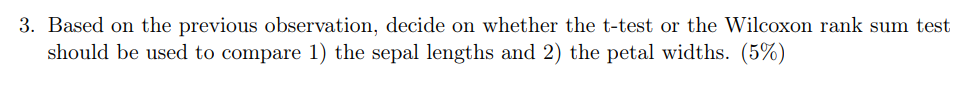

In this case we focused only on Setosa and Versicolor. The T-test has two main assumptions. 1.) The two random variables are noramlly distributed, 2.) the variances of the two random variables are more or less equal. As can be seen by the Shapiro-Wilk test, the sepal lenghts of Setosa and Versicolor are normally distibuted, while the petal widths of these two species are not normally distributed. When we comapre the variances of petal width and sepal length in Setosa and Versicolor, we also see that they are not equal. So the sepal length only satisifes one of the T-test assumptions, while the petal width satisifes none of the assumptions. Because of that we should use the Wilcoxon rank sum test.

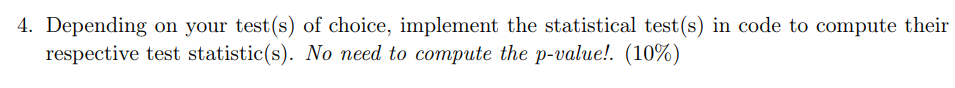

In [130]:
wilcoxon_ranks_sum <- function(sample1, sample2){
    
    # function to create ranks    
    ranking <- function(vector_in){
        ranked <- 1:length(vector_in)
        for (i in sort(unique(vector_in))){
          x1 <- which(sort(vector_in) == i)
          x2 <- c(which(vector_in == i))    
          for (i in 1:length(x2)){
            suppressWarnings(ranked[x2[i]] <- rep(mean(x1), length(x1)))
          }
        }
        return(ranked)
    }
    
    # calculate the test statistic
    combined <- c(sample1, sample2)
    sample1_idx <- rep(1, length(sample1))
    sample2_idx <- rep(2, length(sample2))
    df <- data.frame(rbind(cbind(sample1, sample1_idx),cbind(sample2, sample2_idx)))
    colnames(df) <- c('values', 'from_which_sample')
    df_sorted <- df[order(df$values), ]
    df_sorted$ranks <- rank(df_sorted$values)
    sample1_ranks <- df_sorted[df_sorted$from_which_sample == 1,3]
    sample2_ranks <- df_sorted[df_sorted$from_which_sample == 2,3]
    W1 <- sum(sample1_ranks)
    W2 <- sum(sample2_ranks)
    n_sample1 <- length(sample1)
    n_sample2 <- length(sample2)
    U1 <- W1 - (n_sample1*(n_sample1 + 1))/2
    U2 <- W2 - (n_sample2*(n_sample2 + 1))/2
    U <- min(U1, U2)
    return(U)
}

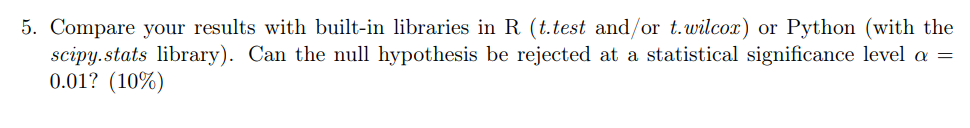

#### 5.1. Sepal Lenght in Setosa vs Versicolor

In [135]:
wilcoxon_ranks_sum(sample1 = setosa$Sepal.Length, sample2 = versicolor$Sepal.Length)
wilcox.test(x = setosa$Sepal.Length, y = versicolor$Sepal.Length)

[1] 168.5


	Wilcoxon rank sum test with continuity correction

data:  setosa$Sepal.Length and versicolor$Sepal.Length
W = 168.5, p-value = 8.346e-14
alternative hypothesis: true location shift is not equal to 0


#### 5.2. Petal Width in Setosa vs Versicolor

In [136]:
wilcoxon_ranks_sum(sample1 = setosa$Petal.Width, sample2 = versicolor$Petal.Width)
wilcox.test(x = setosa$Petal.Width, y = versicolor$Petal.Width)

[1] 0


	Wilcoxon rank sum test with continuity correction

data:  setosa$Petal.Width and versicolor$Petal.Width
W = 0, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In both cases (Petal Width and Sepal Length), the null hypothesis can be rejected with a significance level of 0.01.